In [1]:
%cd LostGANs
# !pip install -r requirements.txt
# !pip install h5py

/home/ec2-user/SageMaker/myLostGANs/LostGANs


In [2]:
import math, argparse
import os, pickle, time, datetime, torch, random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torchvision.utils import make_grid
from utils.util import *
from data.cocostuff_loader import *
from data.vg import *
from model.resnet_generator_v2 import *
from model.rcnn_discriminator import *
from model.sync_batchnorm import DataParallelWithCallback
from utils.logger import setup_logger
from torch.optim.optimizer import Optimizer, required
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

ImportError: cannot import name '_C' from 'model.roi_layers' (/home/ec2-user/SageMaker/myLostGANs/LostGANs/model/roi_layers/__init__.py)

In [ ]:
class MyParams:
    def __init__(self, total_epoch):
        self.dataset = 'coco'
        self.model_path = 'pretrained_model/netGv2_coco128.pth'
        self.batch_size = 2
        self.total_epoch = total_epoch

In [ ]:
def my_normalization(x):
    # x[i] --> percentage of elements in x that are <= x[i]
    quantiles = (torch.argsort(x.reshape((-1))).reshape((x.shape)).to(torch.float)+.5)/torch.numel(x)
    normal = torch.distributions.Normal(0,1)
    return normal.icdf(quantiles).to(torch.float)

In [30]:
def bbox_normalization(bboxes, labels):
    batch_size = labels.shape[0]
    res = bboxes.clone()
    for b in range(batch_size):
        label = labels[b]
        bbox  = bboxes[b]
        
        for i, a in enumerate([-.6,-.6,.5,.5]):
            res[b,label == 0,i] = a
        x0 = bbox[label != 0,0]
        y0 = bbox[label != 0,1]
        x1 = bbox[label != 0,2]
        y1 = bbox[label != 0,3]
        # sometimes x0+y0 sum up to less than 1. The choice of 3 is arbitrary
    #     x_sum = x0 + x1 #+ torch.rand((x0.shape))/3
    #     y_sum = y0 + y1 #+ torch.rand((x0.shape))/3
    #     res[:,label != 0,0] =  x0 / x_sum
    #     res[:,label != 0,2] =  x1 / x_sum
    #     res[:,label != 0,1] =  y0 / y_sum
    #     res[:,label != 0,3] =  x1 / y_sum


        # x0 + x1 == .6  --> x0 + x1 == .7
        # x0 + x1 == .8  --> x0 + x1 == .8
        # x0 + x1 == 1.1 --> x0 + x1 == 1
        x_cur_sum = x0 + x1
        y_cur_sum = y0 + y1
        x_new_sum = (x_cur_sum <= .7) * .7 + (x_cur_sum >= 1) * 1 + (x_cur_sum > .7)*(x_cur_sum < 1)*x_cur_sum
        y_new_sum = (y_cur_sum <= .7) * .7 + (y_cur_sum >= 1) * 1 + (y_cur_sum > .7)*(y_cur_sum < 1)*y_cur_sum
        res[b,label != 0,0] = x0 * x_new_sum / x_cur_sum
        res[b,label != 0,2] = x1 * x_new_sum / x_cur_sum
        res[b,label != 0,1] = y0 * y_new_sum / y_cur_sum
        res[b,label != 0,3] = x1 * y_new_sum / y_cur_sum


        res[b,label != 0,:] = res[b,label != 0,:].abs()
    return res


In [31]:
# this function is never called, but its content is used below. It is here for completeness and clarity
def label_normalization(embedded_label, netG, netG_embedding):
    
    return netG_embedding[netG.de_embedding(embedded_label.cuda())[:,:],:]


In [49]:
class MyGD(Optimizer):

    def __init__(self, params):
        defaults = dict()
        super(MyGD, self).__init__(params, defaults)
        self.prev_loss = None
        self.last_best = None
        self.prev_grad = dict()
        self.prev_p = dict()
        self.grad_sum = dict()

    def __setstate__(self, state):
        super(MyGD, self).__setstate__(state)
        
        # my modified SGD step. Notice it is invariant to multiplying the loss by a scalar
    def step(self, loss, epoch):
        for group in self.param_groups:
            for p in group['params']:
#                 if p.shape[2]!=128: #not z
#                     continue

                alpha = 100 # consider 10 or less, instead
                    
#                 if self.prev_loss != None:
                if p in self.grad_sum:
                    correlation = torch.dot(self.prev_grad[p].reshape((-1)) , p.grad.reshape((-1)))  / (torch.norm(self.prev_grad[p]) * torch.norm(p.grad.reshape((-1))))
#                     p.data = p-1000*p.grad*loss/self.prev_loss
                    # the step size is bigger as much as the loss is greater than its linear approximation
#                     p.data = p-alpha*(p.grad/torch.norm(p.grad))*(loss/(self.prev_loss + torch.dot( self.prev_grad.reshape((-1)), (p.data-self.prev_p).reshape((-1))  ) ))
#                     p.data = p-alpha*(p.grad/torch.norm(p.grad))*(loss/self.prev_loss)
                    
                    
                    self.grad_sum[p] = 2/3 * self.grad_sum[p] + 1/3 * p.grad 
                    
                    p_grad = self.grad_sum[p]
                    p.data = p-2**correlation*(p_grad/torch.norm(p_grad))*(loss/self.prev_loss)
#                     print("epoch: %d, cor: %f, 2**cor: %f, loss: %f" % (epoch, correlation, 2**correlation, loss))
                    
                    
                    
                else:
                    self.grad_sum[p] = p.grad.clone()
                
                self.prev_loss = loss
                self.prev_grad[p] = p.grad.clone()
                self.prev_p[p] = p.data


In [39]:
def get_dataset(dataset, img_size):
    if dataset == "coco":
        data = CocoSceneGraphDataset(image_dir='./datasets/coco/images/train2017/',
                                        instances_json='./datasets/coco/annotations/instances_train2017.json',
                                        stuff_json='./datasets/coco/annotations/stuff_train2017.json',
                                        stuff_only=True, image_size=(img_size, img_size), left_right_flip=True)
    elif dataset == 'vg':
        data = VgSceneGraphDataset(vocab=vocab, h5_path='./datasets/vg/train.h5',
                                      image_dir='./datasets/vg/images/',
                                      image_size=(img_size, img_size), max_objects=10, left_right_flip=True)
    return data



In [40]:
cosine_sim = lambda x : torch.dot(x[0].reshape((-1)).to(torch.float),x[1].reshape((-1)).to(torch.float) ) / (torch.norm(x[0].reshape((-1)).to(torch.float) ) * torch.norm(x[1].reshape((-1)).to(torch.float) ))
#     cosine_sim = lambda x : nn.CosineSimilarity()(x[0].reshape((-1)).to(torch.float), x[1].reshape((-1)).to(torch.float))


In [92]:
def my_train(image_path, args):
    global real_images, real_label, real_bbox, netG
        
    boxes = []
    

    
    # make fake repetitions for the batch_size (=2), rather than real diversity.
    # the reason is that we must have batch_size >= 2, because we have Batch Normalization, but we actually need here batch_size == 1, so we make a "cheat" here
    real_images = real_images[0].repeat(args.batch_size,1,1,1)
    real_label  = real_label [0].repeat(args.batch_size,1)
    real_bbox   = real_bbox  [0].repeat(args.batch_size,1,1)

    
    from_zero = True
    if from_zero:
        embedded_label =torch.rand((args.batch_size,  num_obj, embedding_dim))
        bbox = torch.rand((args.batch_size, num_obj, 4))
#         bbox = 2*torch.rand((args.batch_size, num_obj, 4))-1
    else:
#         embedded_label = netG_embedding(num_classes, 180) , real_label (batch, num_obj)
        embedded_label = netG_embedding[real_label[0,:],:].repeat(args.batch_size,1,1)
        bbox = real_bbox
    embedded_label = netG_embedding[real_label[0,:],:].repeat(args.batch_size,1,1)
#     z = torch.randn(args.batch_size, num_obj, z_dim)
    z = torch.randn(1, num_obj, z_dim).repeat(args.batch_size, 1, 1)
        
    
    flip = False # isn't it?

    
    
    embedded_label = torch.nn.Parameter(embedded_label, requires_grad=True)
    bbox           = torch.nn.Parameter(bbox,           requires_grad=True)
    z              = torch.nn.Parameter(z,              requires_grad=True)
    
    
    param_list = [embedded_label, bbox, z] #should it also contain flip?
    
    
          
    

    optim = MyGD(param_list)
#     optim = torch.optim.SGD(param_list, lr=1e-4)
#     optim = torch.optim.SGD(param_list, lr=0.001, momentum=0.7) 
#     optim = torch.optim.Adam(param_list)
    
    
    vgg_loss = VGGLoss()
    vgg_loss = nn.DataParallel(vgg_loss)
    l1_loss = nn.DataParallel(nn.L1Loss())
    
    g_losses     =  np.random.rand((args.total_epoch))
    feat_losses  =  np.random.rand((args.total_epoch))
    pixel_losses =  np.random.rand((args.total_epoch))
    z_losses     =  np.random.rand((args.total_epoch))
    bbox_losses  =  np.random.rand((args.total_epoch))
    label_losses =  np.random.rand((args.total_epoch))
    label_sim    =  np.random.rand((args.total_epoch))
    bbox_sim     =  np.random.rand((args.total_epoch))
    
    
    for epoch in tqdm(range(args.total_epoch)):
        real_images, embedded_label, bbox = real_images.cuda(), embedded_label, bbox.float()
        fake_images = netG(z.cuda(), bbox.cuda(), embedded_y=embedded_label.cuda())
        optim.zero_grad()
            
        
        
        
        z_loss     = l1_loss(z, my_normalization(z))
        pixel_loss = l1_loss(fake_images, real_images).mean()
        label      = netG.de_embedding(embedded_label.cuda())
        bbox_loss  = l1_loss(bbox ,bbox_normalization(bbox, label))
        label_loss = l1_loss(embedded_label, label_normalization(embedded_label, netG, netG_embedding).detach())
        feat_loss  = vgg_loss(fake_images, real_images).mean()
        
        g_loss = feat_loss + pixel_loss + z_loss + bbox_loss + label_loss # + g_loss_obj * lamb_obj + g_loss_fake * lamb_img
#         g_loss = pixel_loss

        pred_label, gt_label = embedded_label.cuda(), netG_embedding[real_label,:]
        label_sim[epoch] = cosine_sim([pred_label, gt_label])
        bbox_sim [epoch] = cosine_sim([bbox, real_bbox])
        
        
        
        g_losses[epoch]     = g_loss
        feat_losses[epoch]  = feat_loss
        pixel_losses[epoch] = pixel_loss
        z_losses[epoch]     = z_loss
        bbox_losses[epoch]  = bbox_loss
        label_losses[epoch] = label_loss
        

        
        
        g_loss.backward()
        
        optim.step(g_loss, epoch)
#         optim.step()
        

        
        
        

    epochs = range(args.total_epoch)
    plt.scatter(label_sim, bbox_sim); plt.title("label_sim vs bbox_sim"); plt.show()
#     plt.scatter(epochs, pixel_losses); plt.title("epochs vs bbox_sim"); plt.show()
#     plt.scatter(epochs, bbox_sim); plt.title("epochs vs losses"); plt.show()

#     plt.scatter(epochs, feat_losses); plt.title("epochs vs %s" % ("feat_losses")); plt.show()

    
    for loss in ["g_losses", "feat_losses", "pixel_losses", "z_losses", "bbox_losses", "label_losses", "label_sim", "bbox_sim"]:
        plt.scatter(epochs, eval(loss)); plt.title("epochs vs %s" % (loss)); plt.show()
        
    

    print("TOTAL SIMILARITIES:")
    pred_label, gt_label = embedded_label.cuda(), netG_embedding[real_label,:]
    print("label: %f, bbox: %f\n" % (cosine_sim([pred_label, gt_label]), cosine_sim([bbox, real_bbox])))

    print("bbox:")
    print(bbox)

    WW = HH = 128 # is it true? probably yes, as we calculate the bbox for the TRANSFORMED image, and NOT the original image
    for i in range(8):
        x0,y0,x1,y1 = bbox[0,i,:]
        x = x0 * WW
        y = y0 * HH
        w = x1 * WW
        h = y1 * HH
        if flip:
            x0 = 1 - (x0 + x1)
        boxes.append([x.detach(), y.detach(), w.detach(),h.detach()])
        
    
    label_similarity = torch.rand((args.batch_size, num_obj))
    for i in range(args.batch_size):
        for j in range(num_obj):
            # consider averaging on all the batch, and only then applying dot prouct
            x, y = embedded_label[i,j].cuda(), netG_embedding[real_label[i,j],:]
            label_similarity[i,j] =  torch.dot(x,y) / (torch.norm(x) * torch.norm(y))
    
    print("label similarity:")
    print(label_similarity)                            
        
        
    return np.array(boxes).astype(int), real_bbox.cpu(), netG.de_embedding(embedded_label.cuda()).detach().cpu().numpy(), real_label.cpu()


In [93]:
# num_epochs = 2
# args = MyParams(num_epochs)

# # parameters
# img_size = 128
# z_dim = 128
# lamb_obj = 1.0
# lamb_img = 0.1
# num_classes = 184 if args.dataset == 'coco' else 179
# num_obj = 8 if args.dataset == 'coco' else 31
# embedding_dim = 180
# directory = './datasets/coco/images/train2017/'

#     # data loader
# train_data = get_dataset(args.dataset, img_size)

# dataloader = torch.utils.data.DataLoader(
#     train_data, batch_size=args.batch_size,
#     drop_last=True, shuffle=True, num_workers=1)

# for idx, data in enumerate(dataloader):
#     real_images, real_label, real_bbox = data
#     break



# # Load model
# netG = ResnetGenerator128(num_classes=num_classes, output_dim=3, batch_size = args.batch_size, num_obj = num_obj).cuda()
# #     netG.test()

# x = torch.arange(0,num_classes).long().cuda()
# netG_embedding = netG.label_embedding(x).cuda()



# parallel = False
# if parallel:
#     netG = DataParallelWithCallback(netG)

# for param in netG.parameters():
#     param.requires_grad = False 

./datasets/coco/images/train2017/000000311997.jpg


100%|██████████| 150/150 [01:26<00:00,  1.74it/s]


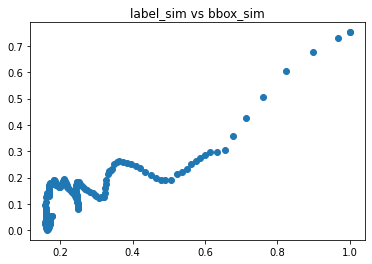

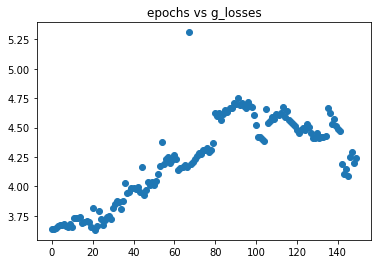

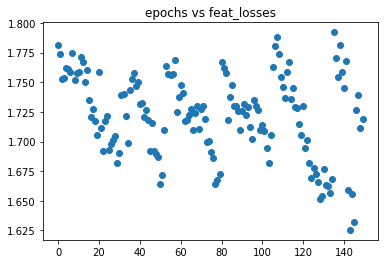

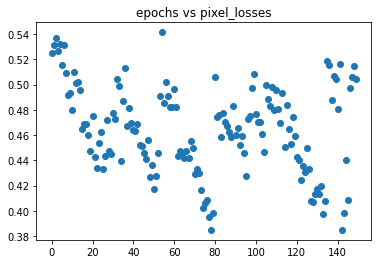

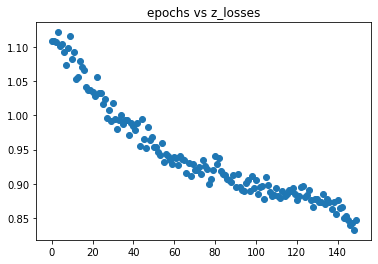

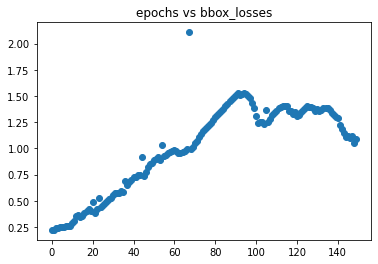

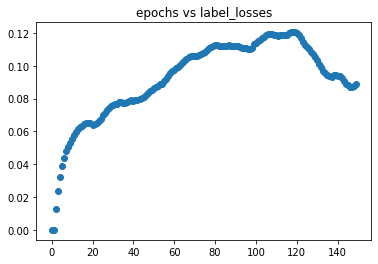

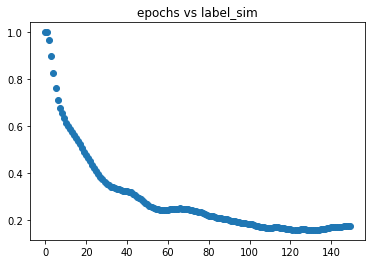

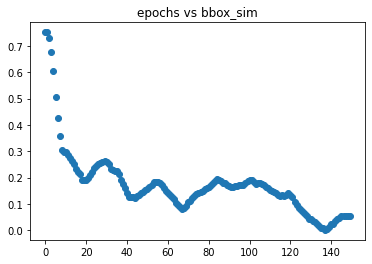

TOTAL SIMILARITIES:
label: 0.177374, bbox: 0.055964

bbox:
Parameter containing:
tensor([[[-1.1742e+00,  4.0933e-02, -8.5059e-01,  8.7817e-01],
         [-6.7232e-01,  6.0455e-01, -3.3210e-01,  3.0922e-01],
         [ 1.2364e+00,  8.6705e-01, -2.8556e-02,  4.5559e-02],
         [-7.9937e+00,  7.5134e-01, -4.4048e-02,  2.2104e-02],
         [-6.8539e-01,  6.7298e-02,  1.0169e+00,  6.1648e-01],
         [ 7.7223e-01, -6.2352e-02,  9.9997e-02, -3.3700e-01],
         [ 7.2277e-01, -1.0642e+00,  1.3432e-01, -8.5378e-01],
         [-4.8835e+00,  1.1181e-02, -5.8519e+00,  2.4697e+00]],

        [[-5.7644e+00,  1.7767e-01, -9.9762e-01,  9.4148e-01],
         [ 3.3366e-01,  1.8110e+00,  4.4057e-01,  2.5675e-01],
         [ 4.1223e-02,  2.2060e+00,  1.0074e+00,  6.6350e-01],
         [ 1.2302e+00,  6.7502e-01,  1.4593e-01,  2.5929e-01],
         [ 2.5527e+00,  6.5593e+00, -2.9614e-03,  6.2623e+00],
         [ 6.3443e-01,  1.1421e+00,  7.3945e-02,  6.6912e-02],
         [-3.7187e+00,  3.6165e-02,

In [94]:
num_epochs = 150
num_files = 1
args = MyParams(num_epochs)
# random_image = True
for file_num, file in zip(range(num_files), os.listdir(directory)):
    
#     if random_image and random.random() < 0.5:
#         continue
    filename = os.fsdecode(file)
    filepath = directory+file
    print(filepath)
    bbox, true_bbox, label, true_label = my_train(filepath, args)
    print("bbox:")
    print(bbox)
    print("true bbox:")
    print(true_bbox)
    print("label:")
    print(label)
    print("true label:")
    print(true_label)
    